## BLOB Analysis in Python

In [1]:
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb

In [217]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8), sharex=True,
                                   sharey=True)
    if len(original.shape) == 3: # RGB image
        ax1.imshow(original)
    else: # Grayscale image
        ax1.imshow(original, cmap='gray')
    ax1.set_title('Original')
    ax1.axis('off')
    if len(modified.shape) == 3: # RGB image
        ax2.imshow(modified)
    else: # Grayscale image
        ax2.imshow(modified, cmap='gray')
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [36]:
from skimage import filters

In [66]:
def image_to_binary(img: np.ndarray):
    """
    Converts an RGB image to a binary image using Otsu's thresholding
    Returns a binary image as a numpy array (dtype: bool)
    """
    if len(img.shape) == 3:
        img_gray = color.rgb2gray(img)
    else:
        img_gray = img
    thresh = filters.threshold_otsu(img_gray)
    img_bin = img_gray < thresh
    #Map the boolean values to 0 and 255
    #img_bin = img_bin.astype(np.uint8) * 255
    return img_bin


### Exercise 1
Show comparison of RGB and binary image using otsu thresholding

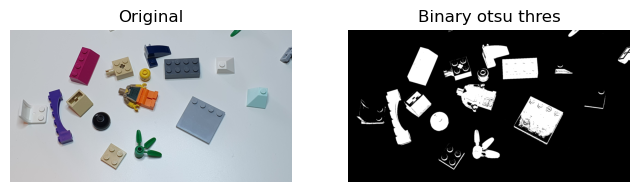

In [38]:
data_dir = './data/'
image_name = 'lego_4_small.png'
img_org = io.imread(data_dir + image_name)

img_bin = rgb_to_binary(img_org)
show_comparison(img_org, img_bin, 'Binary otsu thres')

### Exercise 2
Remove border BLOBs

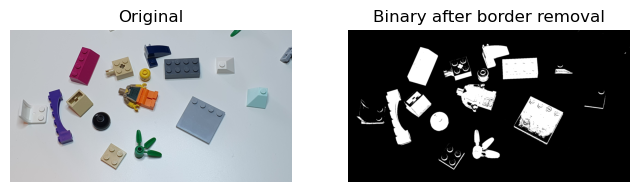

In [39]:
# Apply segmentation.clear_border
img_bin = segmentation.clear_border(img_bin)
show_comparison(img_org, img_bin, 'Binary after border removal')

### Exercise 3
Clean using various morphological operations to remove noise and close gaps, first closing, followed by opening, disc size radius 5

In [19]:
def apply_closing(img, disk_size):
    footprint = morphology.disk(disk_size)
    img_closed = morphology.closing(img,footprint)
    return img_closed

def apply_opening(img, disk_size):
    footprint = morphology.disk(disk_size)
    img_open = morphology.opening(img,footprint)
    return img_open

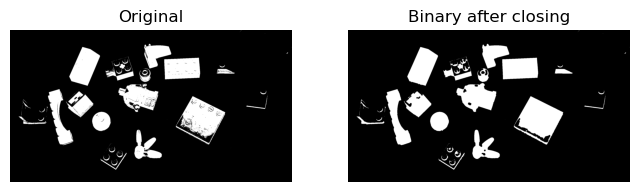

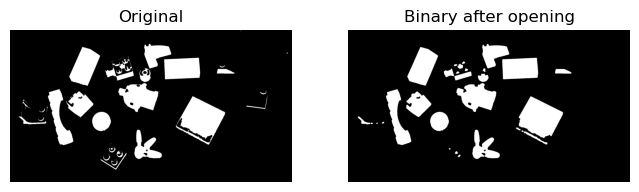

In [43]:
img_close = apply_closing(img_bin, 5)
show_comparison(img_bin, img_close, 'Binary after closing')
img_open = apply_opening(img_close, 5)
show_comparison(img_close, img_open, 'Binary after opening')

### Exercise 4: Find labels

In [44]:
label_img = measure.label(img_open)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 29


### Exercise 5, vizualise found labels

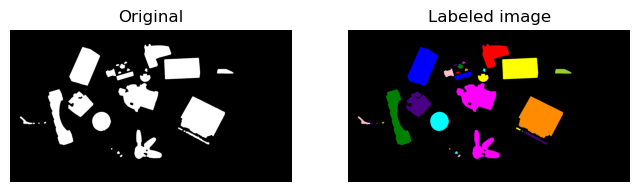

In [46]:
#Visualize the labels using label2rbg 
img_label = label2rgb(label_img, bg_label=0)
show_comparison(img_open, img_label, 'Labeled image')

### Exercise 6: Compute blob features

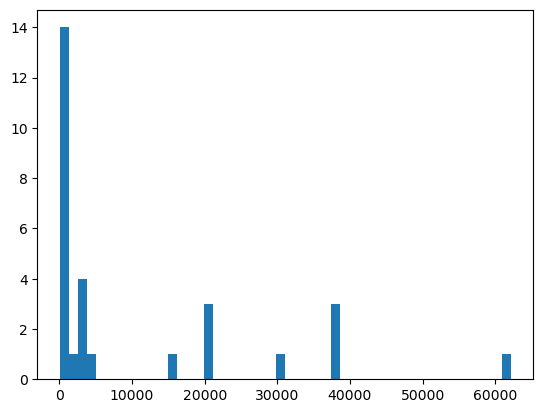

In [47]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

### Exercise 7: Exploring BLOB features

In [53]:
#Run bash command python to run the file Ex5-BlobAnalysisInteractive.py
!conda activate imageanalysis1
!python ./data/Ex5-BlobAnalysis.py

Number of labels: 29
Figure(800x400)
[21111 38369 38053   275  1036   262   338   377  2953  3330   298  4195
  3387 38515 30914 20229 62155 15086  1604   166    81   143   373 20370
   135  2613   100   321   229]
Figure(640x480)


## Cell counting
### Exercise 8: Threshold selection
Select an appropriate threshold, that seperates nuclei from the background. You can set it manually or use Otsus method.

Show the binary image together with the original image and evaluate if you got the information you wanted in the binary image.

It can be seen that there is some noise (non-nuclei) present and that some nuclei are connected. Nuclei that are overlapping very much should be discarded in the analysis. However, if they are only touching each other a little we can try to separate them. More on this later.

To make the following analysis easier the objects that touches the border should be removed.


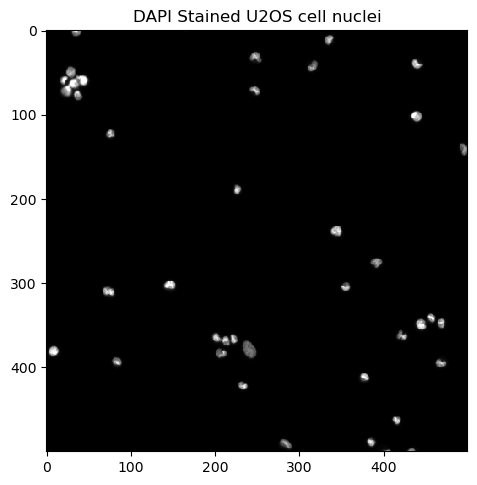

In [58]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
# slice to extract smaller image
img_small = img_org[700:1200, 900:1400]
img_gray = img_as_ubyte(img_small) 
io.imshow(img_gray, vmin=0, vmax=100)
plt.title('DAPI Stained U2OS cell nuclei')
io.show()

In [67]:
img_small.dtype
img_small.shape

(500, 500)

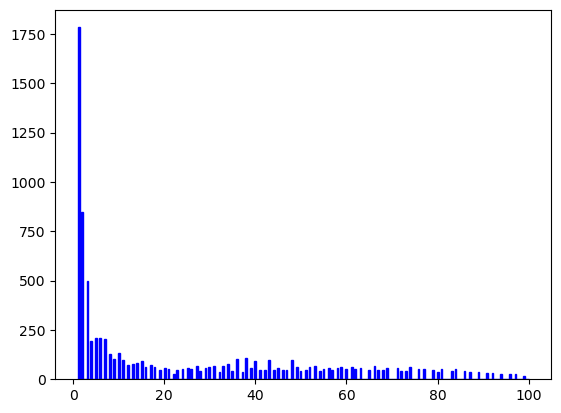

In [62]:
#plot a histogram of the image
plt.hist(img_gray.ravel(), bins=256, range=(1,100), fc='b', ec='b');

Otsu's threshold: 30


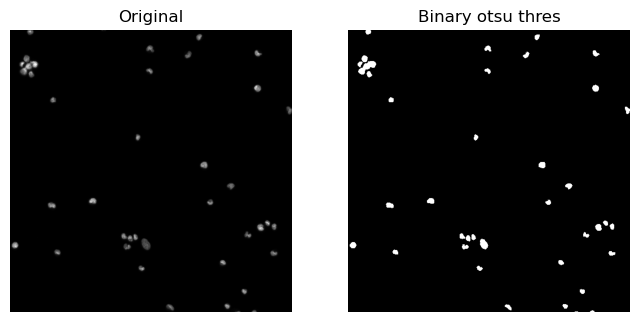

In [81]:
thres = threshold_otsu(img_gray)
print(f"Otsu's threshold: {thres}")
img_bin = img_as_ubyte(img_gray > thres)
show_comparison(img_gray, img_bin, 'Binary otsu thres')

Manual threshold: 40


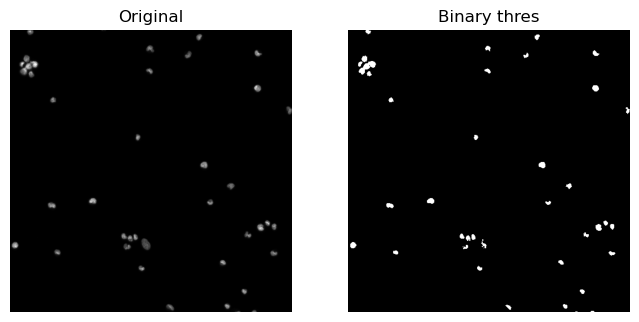

In [94]:
thres = 40
print(f"Manual threshold: {thres}")
img_bin = img_as_ubyte(img_gray > thres)
show_comparison(img_gray, img_bin, 'Binary thres')

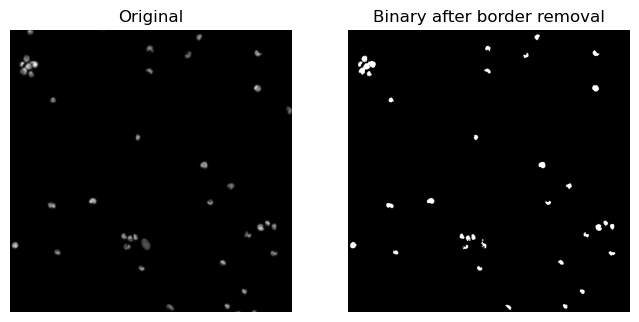

In [95]:
#Remove border
img_bin = segmentation.clear_border(img_bin)
show_comparison(img_gray, img_bin, 'Binary after border removal')

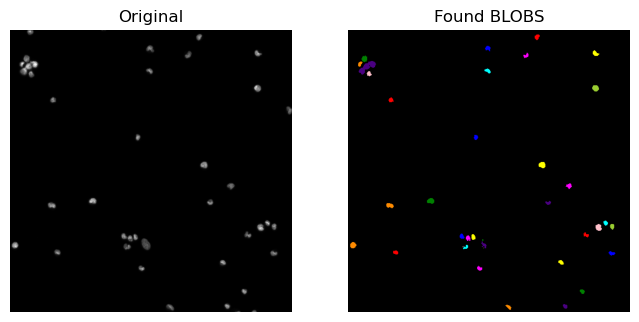

In [96]:
label_img = measure.label(img_bin)
image_label_overlay = label2rgb(label_img)
show_comparison(img_gray, image_label_overlay, 'Found BLOBS')

Number of labels: 37


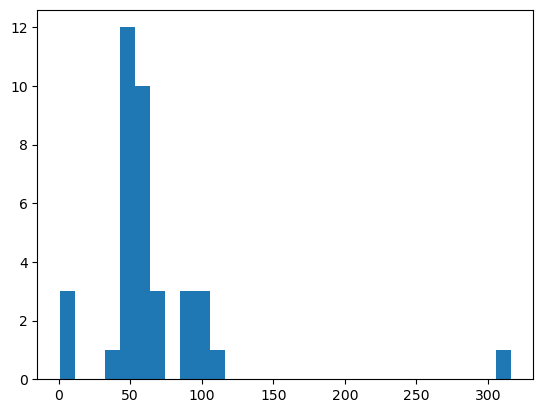

In [99]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
print(f"Number of labels: {len(areas)}")
plt.hist(areas, bins=30);

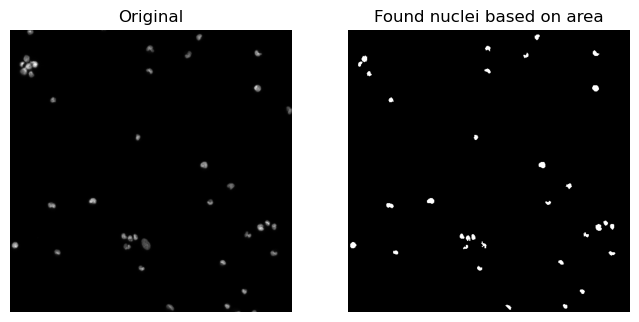

In [121]:
min_area =30
max_area =150

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

### Perimeter and area


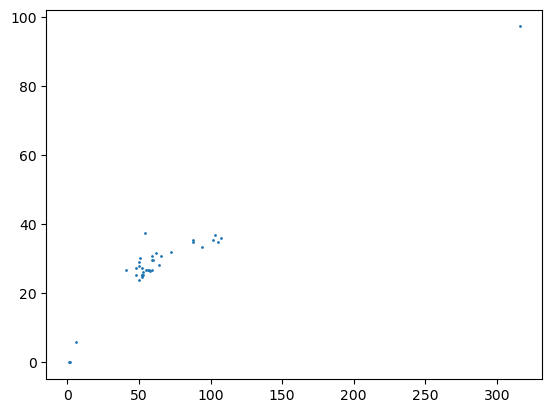

In [143]:
perimeters = np.array([prop.perimeter for prop in region_props])

#plot both area and perimeter in the same plot 
plt.scatter(areas, perimeters, s=1)

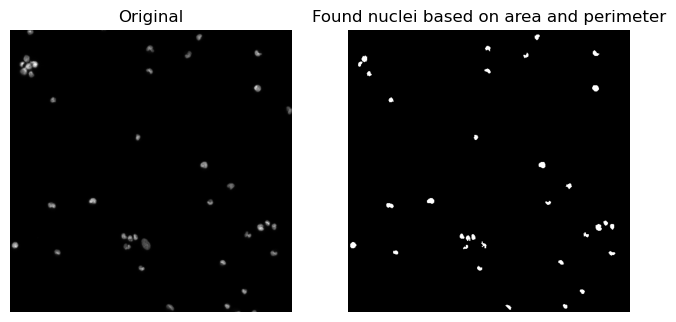

In [104]:
min_area =30
max_area =150
min_perimeter = 20
max_perimeter = 50

# Create a copy of the label_img
img_bin = segmentation.clear_border(img_bin)
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area and region.perimeter > max_perimeter or region.area < min_area and region.perimeter < min_perimeter:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area and perimeter')

In [126]:
np.min(perimeters) #Problem of areas with perimiter = 0, that arise from 1 pixel value blobs

0.0

In [147]:
#Remove blobs with area smaller than 30
label_img = measure.label(img_bin)

min_area =10
max_area =300

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image


label_img = measure.label(label_img_filter)
region_props = measure.regionprops(label_img )
areas = np.array([prop.area for prop in region_props])
perimeters = np.array([prop.perimeter for prop in region_props])

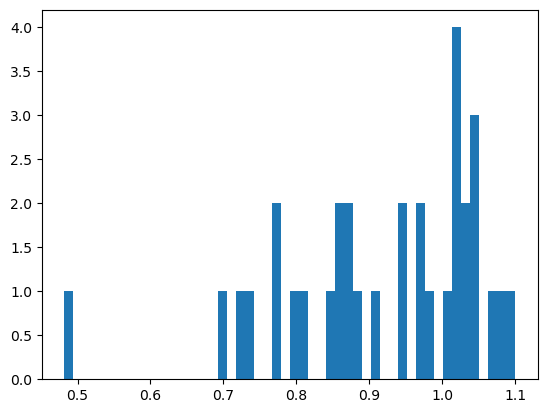

In [150]:
#Calculate the circularity of all blobs, problem of some perimeters being 0, hence ading 1 to the perimeter
circularities = 4*np.pi*areas/(perimeters**2)
plt.hist(circularities, bins=50);

### Exercise 14 & 15 BLOB circularty and scale testing

Otsus threshold: 30


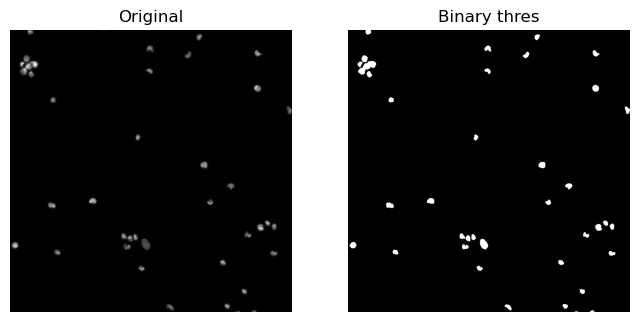

In [181]:
#Apply otsus thres
thres = filters.threshold_otsu(img_gray)
print(f"Otsus threshold: {thres}")
img_bin = img_as_ubyte(img_gray > thres)
show_comparison(img_gray, img_bin, 'Binary thres')

In [228]:
def nuclei_filter(img_binary: np.array, min_circ: float, max_circ: float, min_area: float, max_area: float):
    """	
    Filter blobs based on circularity
    Parameters
    ----------
    img_bin : binary image
        Binary image of the blobs
    min_circ : float
        Minimum circularity
    max_circ : float    
        Maximum circularity 
    Returns
    -------
    img_bin : binary image
        Binary image of the blobs after filtering and with border pixels removed
    """
    
    img_bin = segmentation.clear_border(img_binary)
    img_label = measure.label(img_bin)
    region_props = measure.regionprops(img_label)

    for region in region_props:
        if region.perimeter == 0:
            #print("Warning: Perimeter of 0 found, setting this group to background")
            for cords in region.coords:
                img_bin[cords[0], cords[1]] = 0
                #do not calculate circularity for this region
            continue
        circ = 4*np.pi*region.area/(region.perimeter**2)
        if circ > max_circ or circ < min_circ or region.area > max_area or region.area < min_area:
            for cords in region.coords:
                img_bin[cords[0], cords[1]] = 0
    
    img_label_updated = measure.label(img_bin)
    region_props_updated = measure.regionprops(img_label_updated)
    print(f"Number of nuclei found: {len(region_props_updated)}")      
    return img_bin

142
Number of nuclei found: 34


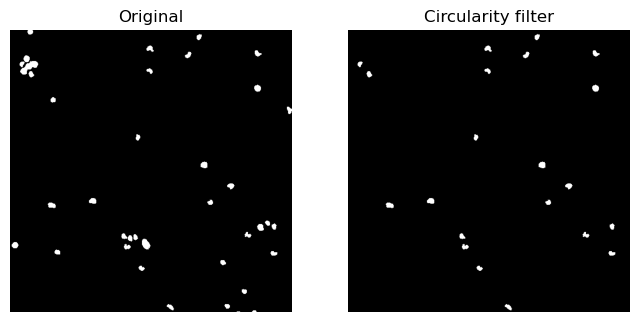

In [205]:
img_gray = img_as_ubyte(img_org[700:1200, 900:1400])
print(np.max(img_gray))
img_bin = np.max(img_gray) - image_to_binary(img_gray) #max value - thres to invert the image

img_filtered = nuclei_filter(img_bin, 0.6, 1.0, 10, 150)
show_comparison(img_bin, img_filtered, 'Circularity filter')

In [206]:
#Number of nuclei (blobs) in the image
label_img = measure.label(img_filtered)
region_props = measure.regionprops(label_img)
print(f"Number of nuclei: {len(region_props)}")

Number of nuclei: 21


203


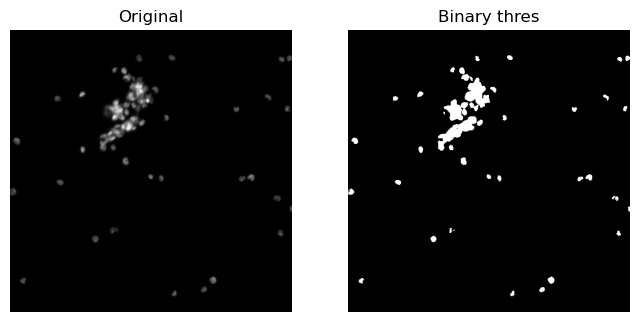

In [207]:
#Try on another section of the image
img_gray = img_as_ubyte(img_org[0:500, 0:500])
print(np.max(img_gray))
img_bin = np.max(img_gray) - image_to_binary(img_gray) #max value - thres to invert the image
show_comparison(img_gray, img_bin, 'Binary thres')

Number of nuclei found: 37


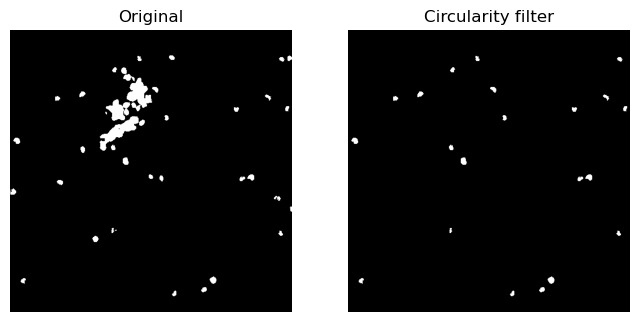

Number of nuclei: 21


In [208]:
img_filtered = nuclei_filter(img_bin, 0.6, 1.0, 10, 150)
show_comparison(img_bin, img_filtered, 'Circularity filter')
#Number of nuclei (blobs) in the image
label_img = measure.label(img_filtered)
region_props = measure.regionprops(label_img)
print(f"Number of nuclei: {len(region_props)}")

255


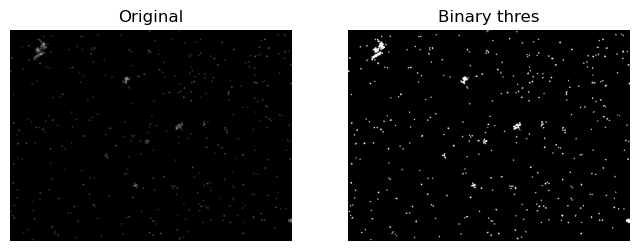

Number of nuclei found: 393


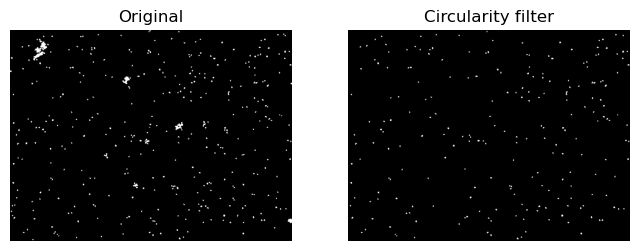

Number of nuclei: 225


In [209]:
#On entire image
img_gray = img_as_ubyte(img_org)
print(np.max(img_gray))
img_bin = np.max(img_gray) - image_to_binary(img_gray) #max value - thres to invert the image
show_comparison(img_gray, img_bin, 'Binary thres')

img_filtered = nuclei_filter(img_bin, 0.6, 1.0, 10, 150)
show_comparison(img_bin, img_filtered, 'Circularity filter')
#Number of nuclei (blobs) in the image
label_img = measure.label(img_filtered)
region_props = measure.regionprops(label_img)
print(f"Number of nuclei: {len(region_props)}")

### Exercise 16


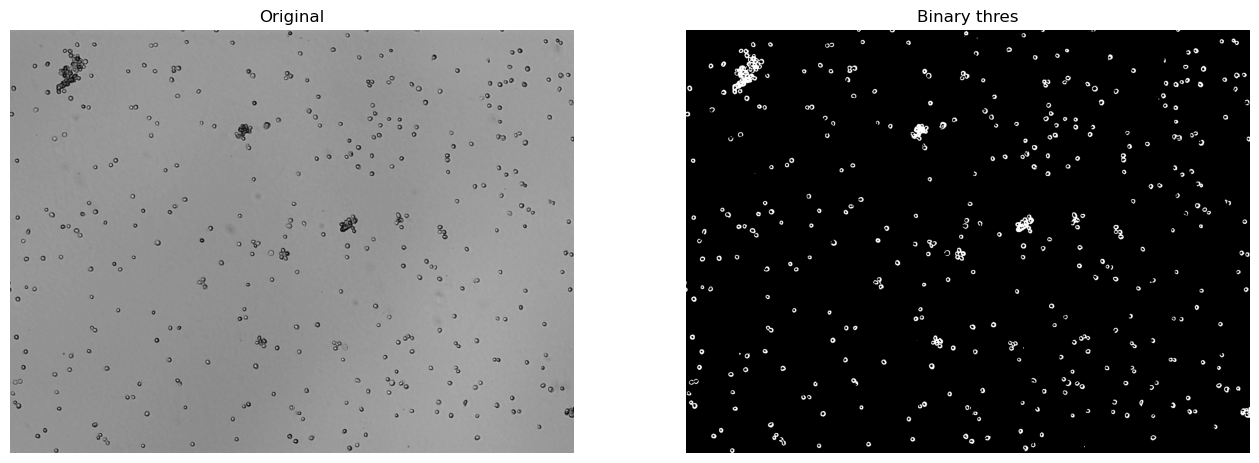

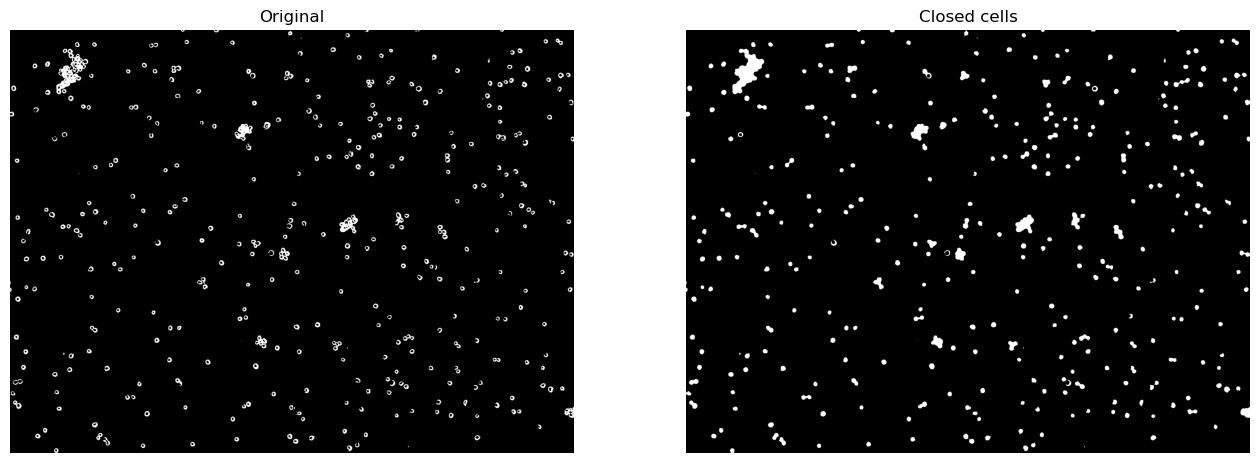

In [225]:
img_2 = io.imread("data/Sample E2 - U2OS AP channel.tiff")

#On entire image
img_gray = img_as_ubyte(img_2)
img_bin = image_to_binary(img_gray) #max value - thres to invert the image
show_comparison(img_gray, img_bin, 'Binary thres')
#Cells have a somewhat empty center so we can fill these using closing
img_closed = apply_closing(img_bin, 5)
show_comparison(img_bin, img_closed, 'Closed cells')

In [ ]:
i_circ = label_img_filter > 0

Number of nuclei found: 187


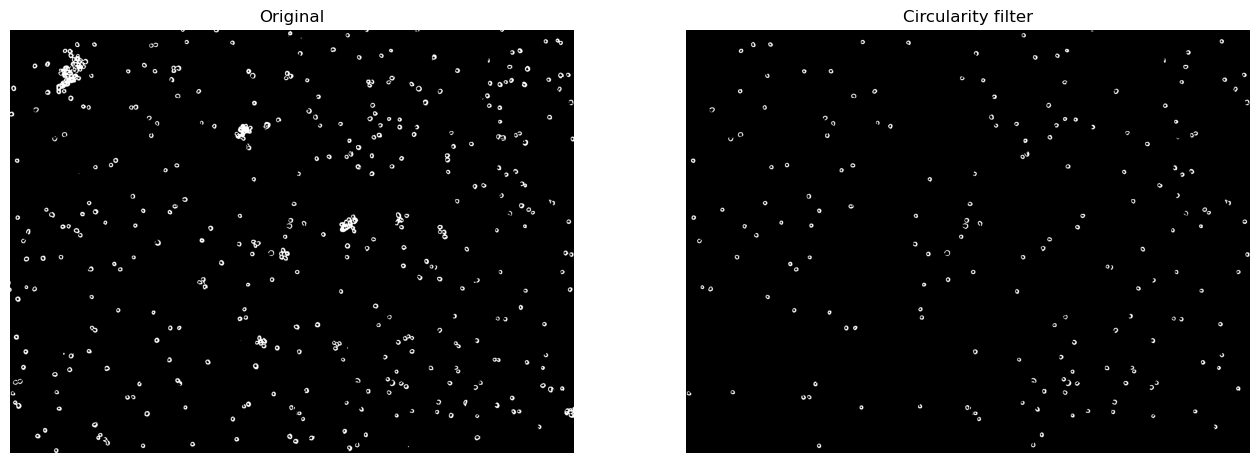

In [233]:
img_filtered = nuclei_filter(img_bin, 0.0, 1.0, 10, 150)
show_comparison(img_bin, img_filtered, 'Circularity filter')